In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/四下/pattern_recognition/HW/HW4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/四下/pattern_recognition/HW/HW4


In [2]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


In [3]:
import numpy as np
import pandas as pd
from nbpep8.nbpep8 import pep8
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [4]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

# 550 data with 300 features
print(x_train.shape)

# It's a binary classification problem
print(np.unique(y_train))
pep8(_ih)

(550, 300)
[0 1]



## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    # Init
    n_samples = len(y_train)
    all_indices = np.arange(n_samples)

    # Save the split
    split = []
    quotient = n_samples // k
    remainder = n_samples % k
    last_idx = 0
    for i in range(k):
        last_idx += quotient
        last_idx += 1 if (remainder > 0 and i < remainder) else 0
        split.append(last_idx)

    # Shuffle and keep the fold
    k_folds = []
    np.random.seed(10)
    np.random.shuffle(all_indices)
    for i in range(k):
        if i == 0:
            test = all_indices[np.arange(split[i])]
        else:
            test = all_indices[np.arange(split[i - 1], split[i])]
        val = np.delete(all_indices, test)
        k_folds.append([val, test])
    return k_folds


pep8(_ih)

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)

# should contain 10 fold of data
assert len(kfold_data) == 10

# each element should contain train fold and validation fold
assert len(kfold_data[0]) == 2

# The number of data in each validation fold
assert kfold_data[0][1].shape[0] == 55
assert kfold_data[0][0].shape[0] == 55 * (10 - 1)
pep8(_ih)

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

* In the [guide](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf), it says that since doing a complete grid-search may still be time-consuming, it's recommended to use a coarse grid first. 
* After identifying a “better” region on the grid, a finer grid search on that region can be conducted.

In [7]:
def grid_search(kfold_data, cs, gammas):
    cov = np.zeros((len(cs), len(gammas)))
    max_acc = 0.0
    best = {'c': -1, 'g': -1}
    for i, c in enumerate(cs):
        for j, g in enumerate(gammas):
            # Taking average on the validation accuracy
            total_err = 0.0
            for kf in kfold_data:
                train_idx, val_idx = kf[0], kf[1]
                clf = SVC(C=c, kernel='rbf', gamma=g)
                clf.fit(x_train[train_idx], y_train[train_idx])
                y_pred = clf.predict(x_train[val_idx])
                total_err += sum(np.logical_xor(y_train[val_idx], y_pred))
            avg_acc = 1.0 - (total_err / len(y_train))
            if(avg_acc > max_acc):
                max_acc = avg_acc
                best = {'c': c, 'g': g}
            # save in cov-matrix
            cov[i, j] = avg_acc
    print(f"c : {best['c']}, gamma :{best['g']}, max_acc : {max_acc}")
    return cov, best


pep8(_ih)

In [8]:
# Use 5-fold validation
kfold_data = cross_validation(x_train, y_train, k=5)

# Coarse search
c1 = [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]
gamma1 = [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]
cov1, best1 = grid_search(kfold_data, c1, gamma1)

# Finer search
c2 = np.arange(1, 10, 1)
gamma2 = np.round(np.arange(0.001, 0.01, 0.001), 3)
cov2, best2 = grid_search(kfold_data, c2, gamma2)
pep8(_ih)

c : 10, gamma :0.001, max_acc : 0.98
c : 3, gamma :0.002, max_acc : 0.9818181818181818



## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


def heatmap_sns(c, gamma, cov):

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cov,
        vmin=np.min(cov), vmax=1.0, annot=True,
        xticklabels=gamma,
        yticklabels=c,
        cmap=sns.diverging_palette(220, 20, n=7),
        square=True
    )
    ax.set_title('Hyperparameter Gridsearch', fontdict={'fontsize': 12}, pad=9)
    ax.set_xlabel("Gamma Parameter")
    ax.set_ylabel("C Parameter")


pep8(_ih)

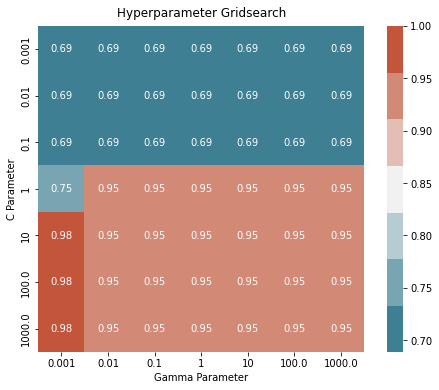

In [10]:
# Coarse grid search
heatmap_sns(c1, gamma1, cov1)
pep8(_ih)

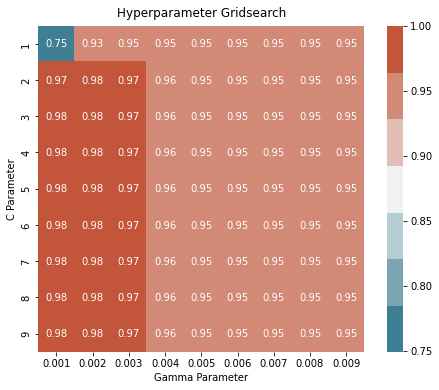

In [11]:
# Fine grid search
heatmap_sns(c2, gamma2, cov2)
pep8(_ih)

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [12]:
print(f"c={best2['c']}, gamma={best2['g']}")

c=3, gamma=0.002


In [13]:
# Train the model by {C: 3, gamma: 0.002} on the whole training data
best_model = SVC(C=best2['c'], kernel='rbf', gamma=best2['g'])
best_model.fit(x_train, y_train)

# Testing accuracy
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))
pep8(_ih)

Accuracy score:  0.9166666666666666

